In [55]:
%matplotlib inline
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from functions.latex import set_size

from matplotlib.collections import LineCollection
from global_land_mask import globe






datadir = "../data/"
figdir = "../figures/"

In [ ]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

def plot_func(var, ax, transform=False, vmin=-5, vmax=5, s=5, linewidth=0, marker=".", cmap="coolwarm"):
    if transform:
        cb = ax.scatter(x=var.lon, y=var.lat, c=var,
                   cmap=cmap,
                   #alpha=1,
                   s=s,
                   linewidth=linewidth,
                   vmin=vmin,
                   vmax=vmax,
                   marker=marker,
                   transform=ccrs.PlateCarree()
                  )
        ax.add_feature(cfeature.LAND, color="grey", zorder=100)
    else:
        cb = ax.scatter(x=var.x, y=var.y, c=var,
                   cmap=cmap,
                   #alpha=1,
                   s=s,
                   linewidth=linewidth,
                   vmin=vmin,
                   vmax=vmax,
                   marker=marker
                  )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    return cb, ax

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """

    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.setdefault("transform", ccrs.PlateCarree())
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    c = np.asarray(c)

# Ensure the contour is closed
    if not (np.isclose(x[0], x[-1]) and np.isclose(y[0], y[-1])):
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        c = np.append(c, c[0])







    isnan = np.isnan(x) | np.isnan(y) | np.isnan(c)
    x, y, c = x[~isnan], y[~isnan], c[~isnan]

    # Unwrap longitude to prevent lines crossing the globe
    x = np.unwrap(np.radians(x), discont=np.radians(180))
    x = np.degrees(x)
    
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

region_contours = {
    #"arctic_ocean" : [800, 1000, 1250, 1500, 1800, 2000, 2300],
    "arctic_ocean" : [1000, 1200, 1400, 1600, 1800, 2000, 2200],
    #"canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3750],
    "canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    "makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    "eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    #"greenland_basin" : [2550, 2625, 2800, 3000, 3200, 3400, 3600],
    #"greenland_basin" : [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700],
    "greenland_basin" : [2600, 2800, 3000, 3200, 3400, 3600],
    #"norwegian_seas" : [2500, 2700, 2900, 3050],
    "norwegian_seas" : [2700, 2800, 2900, 3000, 3100, 3200],
    #"lofoten_basin" : [3150, 3200],
    "lofoten_basin" : [3350, 3400, 3450],
    #"norwegian_basin" : [3150, 3275, 3450, 3600]
    #"norwegian_basin" : [3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]
    "norwegian_basin" : [3400, 3500, 3600, 3700, 3800, 3900]
}

In [31]:
mdt = "dtu"
hydrography = "woa"
vector = ["us", "vs"]
transform = False

In [32]:
ds = xr.merge([xr.open_dataset(datadir + f"velocities_{mdt}_{hydrography}_ease.nc"),
               xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
              ]
             )
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB 47.33 47.5 47.67 47.84 ... 47.67 47.5 47.33
    lon      (y, x) float32 279kB -45.0 -44.78 -44.56 ... 135.4 135.2 135.0
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    mdt      (y, x) float64 558kB ...
    us       (y, x) float64 558kB ...
    vs       (y, x) float64 558kB ...
    ut       (y, x) float64 558kB ...
    vt       (y, x) float64 558kB ...
    ub       (y, x) float64 558kB ...
    vb       (y, x) float64 558kB ...
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...
Attributes:
    long_name:     mean ocean dynamic topography
    units:         m
    actual_range:  [-2.205  2.457]

<xarray.Dataset> Size: 116kB
Dimensions:  (point: 856)
Coordinates:
    lat      (point) float64 7kB 69.52 69.65 69.8 69.95 ... 69.16 69.26 69.36
    lon      (point) float64 7kB 15.86 16.19 16.47 16.72 ... 14.38 14.77 15.17
    x        (point) float64 7kB 156.4 156.7 156.9 157.1 ... 154.5 155.0 155.5
    y        (point) float64 7kB 44.0 44.7 45.42 46.18 ... 41.85 42.43 43.02
  * point    (point) int64 7kB 0 1 2 3 4 5 6 7 ... 849 850 851 852 853 854 855
Data variables:
    mdt      (point) float64 7kB nan -0.05521 -0.05593 ... -0.06434 -0.06265
    us       (point) float64 7kB nan nan 0.02024 0.01607 ... nan 0.04382 0.03715
    vs       (point) float64 7kB nan 0.05526 0.05466 0.05464 ... nan 0.05956 nan
    ut       (point) float64 7kB nan nan 0.01411 0.01572 ... 0.02604 nan nan nan
    vt       (point) float64 7kB nan 0.02698 0.02165 0.01801 ... nan nan nan nan
    ub       (point) float64 7kB nan nan 0.006123 0.0003495 ... nan nan nan
    vb       (point) float64 7kB nan 0.02828 0.

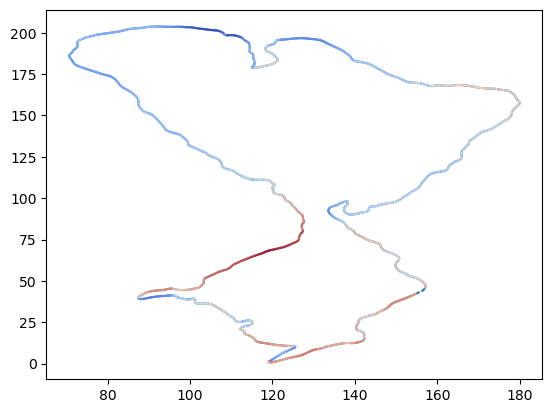

In [19]:
fig, ax = plt.subplots()

contour = xr.open_dataset(datadir + "arctic_ocean" + "/contour_eff_1000.nc")
ds_interp = ds.interp(x=contour.x, y=contour.y)
ds_interp["uc"] = ds_interp["us"]*contour.tx + ds_interp["vs"]*contour.ty
print(ds_interp)

ax.plot(ds_interp.x, ds_interp.y)
ax = colored_line(ds_interp.x.values, ds_interp.y.values, ds_interp.uc.values, ax=ax, cmap="coolwarm")

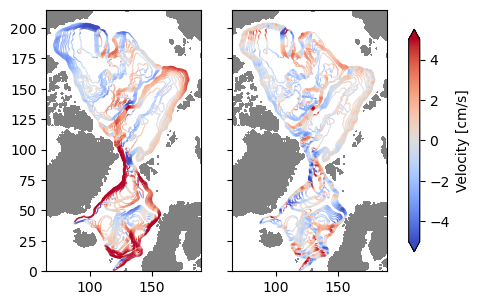

In [54]:
if transform:
    fig, ax = plt.subplots(1, 2,
                           #figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
    proj = "latlon"
else: 
    fig, ax = plt.subplots(1, 2,
                           sharex=True,
                           sharey=True,
                           figsize=set_size(width="AGU"),
                          )
    proj = "xy"

norm = mcolors.Normalize(vmin=-5, vmax=5)

is_on_land = globe.is_land(ds.lat, ds.lon)
land_mask = xr.DataArray(is_on_land, coords=[ds.y, ds.x], dims=["y", "x"])
x = np.arange(land_mask.shape[1])
y = np.arange(land_mask.shape[0])
X, Y = np.meshgrid(land_mask.x, land_mask.y)

for region_name in region_contours:
    region = get_region_coords(region_name, xy=True)
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ds_interp["uc"] = ds_interp[vector[0]]*contour.tx + ds_interp[vector[1]]*contour.ty + (-ds_interp[vector[0]]*contour.ty + ds_interp[vector[1]]*contour.tx)*1j
        
        #ax[0].plot(ds_interp.x, ds_interp.y)
        c = colored_line(ds_interp.x.values, ds_interp.y.values, ds_interp.uc.real.values*100, ax=ax[0],
                         cmap="coolwarm",
                         linewidth=0.8,
                         norm=norm,
                         joinstyle='round'
                         )
        c.set_rasterized(True)
        #ax[1].plot(ds_interp.x, ds_interp.y)
        c = colored_line(ds_interp.x.values, ds_interp.y.values, ds_interp.uc.imag.values*100, ax=ax[1],
                         cmap="coolwarm",
                         linewidth=0.8,
                         norm=norm,
                         #joinstyle='round'
                         )
        c.set_rasterized(True)

ax[0].set_xlim(65, 190)
ax[0].set_ylim(0, 215)
#ax[0].set_aspect(1)
ax[1].set_xlim(65, 190)
ax[1].set_ylim(0, 215)
#ax[0].set_aspect(1)

ax[0].contourf(X, Y, land_mask, levels=[0.5, 1.5], colors=['grey'])
ax[1].contourf(X, Y, land_mask, levels=[0.5, 1.5], colors=['grey'])
fig.colorbar(c,
             ax=ax,
             label="Velocity [cm/s]",
             shrink=0.85,
             extend="both"
            )

fig.savefig(figdir + f"{vector[0]}_alongcontour_{proj}_{mdt}_{hydrography}_lines.pdf", dpi=300, bbox_inches="tight")

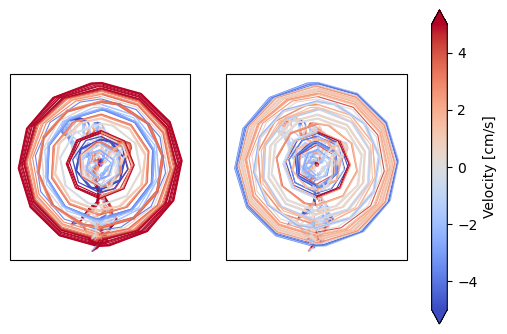

In [68]:
fig, ax = plt.subplots(1, 2,
                        #figsize=set_size(width="AGU"),
                        subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                        )

norm = mcolors.Normalize(vmin=-5, vmax=5)

ds_copy = ds.copy(deep=True)
# Create a condition mask
mask_copy = ds_copy.lon < 0
ds_copy = ds.assign_coords(
            lon=xr.where(mask_copy, ds.lon+360, ds.lon)
        )

for region_name in region_contours:
    region = get_region_coords(region_name, xy=True)
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y, method="linear")
        ds_copy_interp = ds_copy.interp(x=contour.x, y=contour.y, method="linear")
        

        #ds_interp = ds_interp.assign_coords(
        #    lon=xr.where(np.abs(ds_copy_interp.lon - 180) < 1, ds_copy_interp.lon, ds_interp.lon)
        #)

        ds_interp = ds_interp.assign_coords(
                                            lon=xr.where(np.abs(ds_interp.lon) < 1, ds_interp.lon, ds_copy_interp.lon)
                                            )
        ds_interp["uc"] = ds_interp[vector[0]]*contour.tx + ds_interp[vector[1]]*contour.ty + (-ds_interp[vector[0]]*contour.ty + ds_interp[vector[1]]*contour.tx)*1j
        
        ax[0].plot(ds_interp.lon, ds_interp.lat)
        c = colored_line(ds_interp.lon.values, ds_interp.lat.values, ds_interp.uc.real.values*100, ax=ax[0],
                         cmap="coolwarm",
                         linewidth=0.8,
                         norm=norm,
                         #transform=ccrs.PlateCarree(),
                         #joinstyle='round'
                         )
        c.set_rasterized(True)
        ax[1].plot(ds_interp.lon, ds_interp.lat)
        c = colored_line(ds_interp.lon.values, ds_interp.lat.values, ds_interp.uc.imag.values*100, ax=ax[1],
                         cmap="coolwarm",
                         linewidth=0.8,
                         norm=norm,
                         #transform=ccrs.PlateCarree(),
                         #joinstyle='round'
                         )
        c.set_rasterized(True)

#ax[0].set_xlim(65, 190)
#ax[0].set_ylim(0, 215)
ax[0].set_aspect(1)
#ax[1].set_xlim(65, 190)
#ax[1].set_ylim(0, 215)
ax[1].set_aspect(1)

#ax[0].contourf(X, Y, land_mask, levels=[0.5, 1.5], colors=['grey'])
#ax[1].contourf(X, Y, land_mask, levels=[0.5, 1.5], colors=['grey'])
fig.colorbar(c,
             ax=ax,
             label="Velocity [cm/s]",
             shrink=0.85,
             extend="both"
            )

#fig.savefig(figdir + f"{vector[0]}_alongcontour_{proj}_{mdt}_{hydrography}_lines.pdf", dpi=300, bbox_inches="tight")

In [ ]:
if transform:
    fig, ax = plt.subplots(1, 2,
                           #figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
    proj = "latlon"
else: 
    fig, ax = plt.subplots(1, 2,
                           sharex=True,
                           sharey=True
                           #figsize=set_size(width="AGU"),
                          )
    proj = "xy"

for region_name in region_contours:
    region = get_region_coords(region_name, xy=True)
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ds_interp["uc"] = ds_interp[vector[0]]*contour.tx + ds_interp[vector[1]]*contour.ty + (-ds_interp[vector[0]]*contour.ty + ds_interp[vector[1]]*contour.tx)*1j
        
        cb, ax1 = plot_func(ds_interp.uc.real*100, ax=ax[0], transform=transform)
        cb, ax2 = plot_func(ds_interp.uc.imag*100, ax=ax[1], transform=transform)
#ax.set_extent([-10, 20, 60, 90])
fig.colorbar(cb,
             ax=ax,
             label="u [cm/s]",
             shrink=0.85
            )

#fig.savefig(figdir + f"{vector[0]}_alongcontour_{proj}_{mdt}_{hydrography}.png", dpi=300, bbox_inches="tight")